In [4]:
import matplotlib.pyplot as plt
from matplotlib import colors
import six

import numpy as np
import xarray as xr
import pandas as pd
import os

from stompy.grid import unstructured_grid
import stompy.model.data_comparison as dc

import stompy.model.delft.dflow_model as dfm
import pesca_base

In [5]:
six.moves.reload_module(dfm)

INFO:DFlowModel:DelwaqScalarBC instantiated.


<module 'stompy.model.delft.dflow_model' from '/home/rusty/src/stompy/stompy/model/delft/dflow_model.py'>

In [6]:
%matplotlib notebook

In [7]:
# Load the ESA dataset:
esa_waterlevel=xr.open_dataset("../calibration/esa_compiled_waterlevel.nc")

In [8]:
# Load BML dataset:
bml_data_dir="../../data/BML data/2016/all_concatenated"

# BC1 starts later.  All other sites okay for this period.
df=pd.read_csv(os.path.join(bml_data_dir,'csv','NCK_wll_concatenated.csv'))
# UTC
df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
nck_wll=df.set_index('time')

nck_wll.head()

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,year,month,day,hour,minute,second,depth m,temp degC,Unnamed: 8
time,,,,,,,,,
2016-04-06 23:24:00,2016,4,6,23,24,0,11.657694,13.846,NaN
2016-04-06 23:27:00,2016,4,6,23,27,0,11.656686,13.269,NaN
2016-04-06 23:30:00,2016,4,6,23,30,0,11.654668,12.980,NaN
2016-04-06 23:33:00,2016,4,6,23,33,0,11.652651,12.883,NaN
2016-04-06 23:36:00,2016,4,6,23,36,0,11.648617,12.787,NaN


In [235]:
# Load QCM data, too -- code taken from pesca_base.py
qcm_pre2016=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output.csv",                                                                     
                        skiprows=[0],usecols=range(7),                                                                                              
                        parse_dates=['Date (PST)'])                                                                                                 
qcm_2016_2017=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output_4.28.2021.csv",                                                         
                          skiprows=[0],usecols=range(14),                                                                                           
                          parse_dates=['Date (PST)'])                                                                                               
# some extra rows in the csv                                                                                                                        
qcm_2016_2017=qcm_2016_2017[ ~qcm_2016_2017['Date (PST)'].isnull() ]                                                                                
qcm=pd.concat([qcm_pre2016,qcm_2016_2017])                                                                                                          

qcm['time']=qcm['Date (PST)'] + np.timedelta64(8,'h') # Shift to UTC.                                                        
# These are both NAVD88, converted ft=>m                                                                                                            
# Prefer the modified data when available:                                                                                                          
ocean_modified=qcm['Modified Ocean Level (feet NAVD88)']                                                                                            
# Otherwise the observed data.                                                                                                                      
ocean_level=qcm['Ocean level (feet NAVD88)']                                                                                                        
qcm['z_ocean']=0.3048 * ocean_modified.combine_first(ocean_level)
qcm['z_ocean_orig']=0.3048 * ocean_level

qcm['z_thalweg']=0.3048 * qcm['Modeled Inlet thalweg elevation (feet NAVD88)']                                                                      
# width                                                                                                                                             
qcm['w_inlet']=0.3048* qcm['Modeled Inlet Width (feet)']                                                                                            

qcm_ds=xr.Dataset.from_dataframe(qcm[ ['time','z_ocean',
                                       'z_ocean_orig','z_thalweg','w_inlet']
                                    ].set_index('time'))                

In [226]:
# Updated test, using BML data
if 1:
    observed=xr.Dataset.from_dataframe(nck_wll)['depth m'].assign_coords(label='NCK wll')
    # QCM and BML data at NCK differ by about 10.406.
    # This is probably atmospheric pressure? There is still some variability, though
    # some of that could be due to low-pass filtering.
    observed= observed - 10.406  

In [335]:
model=pesca_base.PescaButano.load('run_salt_20160520-v66')

In [336]:
bcs=model.load_bcs()
ocean_bc=[bc for bc in bcs if bc['name']=='ocean_bc'][0]

Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd


In [381]:
from stompy.io.local import noaa_coops

mb_gauge=noaa_coops.coops_dataset_product(station=9413450,
                                          product='water_level',
                                          start_date=model.run_start,
                                          end_date=model.run_stop,
                                          cache_dir='cache')

an_gauge=noaa_coops.coops_dataset_product(station=9413878,
                                          product='predictions',
                                          interval='hilo',
                                          start_date=model.run_start,
                                          end_date=model.run_stop,
                                          cache_dir='cache')

INFO:noaa_coops:Cached   2016-07-01 00:00:00 -- 2016-08-01 00:00:00
INFO:noaa_coops:Cached   2016-07-01 00:00:00 -- 2016-08-01 00:00:00


<IPython.core.display.Javascript object>


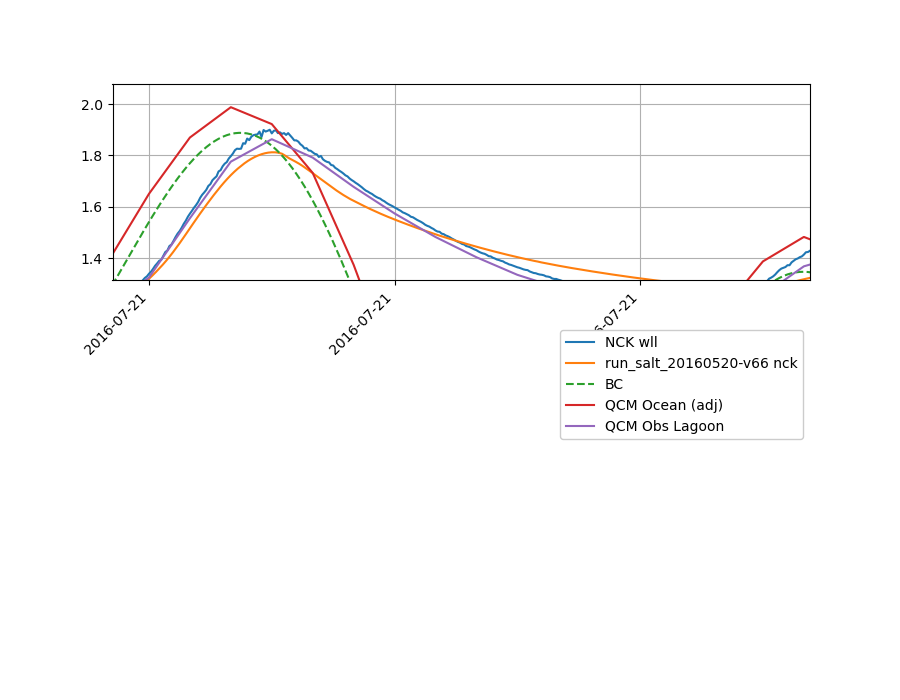

(16991.958333333332, 17005.541666666668, 0.0, 2.0)

In [382]:
import six
six.moves.reload_module(dc)

sources=[observed]

#sources.append( an_gauge.predictions.isel(station=0).assign_coords(label='Año Nuevo') )
#sources.append( mb_gauge.water_level.isel(station=0).assign_coords(label='Monterey'))

if 1: # Model outputs:
    his_ds=xr.open_dataset(model.his_output())

    for model_stn in [ b'nck' ]:
        sel=np.nonzero( his_ds['station_name'].values==model_stn )[0][0]
        predicted=his_ds['waterlevel'].isel(stations=sel)
        predicted=predicted.assign_coords(label=f'{model.run_dir} {model_stn.decode()}')
        sources.append(predicted)
    
    his_ds.close()

sources.append( ocean_bc['data']['stage'].isel(node=0).assign_coords(label='BC'))

fig=dc.calibration_figure_3panel(sources,trim_time=False,lowpass=False,metric_x=None,
                                 offset_source=None)
fig.axes[2].set_visible(0)
fig.axes[1].set_visible(0)

ax=fig.axes[0]
ax.axis([16957.813032803748, 16958.72289133207,0,2])

plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
ax.grid(1)

ax.lines[-1].set_linestyle('--')

if 1: # Add in QCM time series
    ax.plot(qcm.time,qcm.z_ocean,label='QCM Ocean (adj)')
    #ax.plot(qcm.time,qcm.z_ocean_orig,label='QCM Ocean (orig)')
    ax.plot(qcm.time,qcm['Observed Lagoon Level (feet NAVD88)']*0.3048,
            label='QCM Obs Lagoon')

ax.legend(loc='upper right',bbox_to_anchor=[1.0,-0.22],
          framealpha=1.0)
ax.axis( xmin=his_ds.time.values[0]-np.timedelta64(1,'h'),
         xmax=his_ds.time.values[-1]+np.timedelta64(1,'h'))

In [386]:
# Compare observed lagoon level from QCM and BML 
# This just to establish the offset (which is applied
# above)
if 0:
    qcm['z_lagoon']=qcm['Observed Lagoon Level (feet NAVD88)']*0.3048
    ds_qcm_lagoon=xr.Dataset.from_dataframe(qcm.set_index('time'))['z_lagoon']
    dc.calibration_figure_3panel([ds_qcm_lagoon,observed],trim_time=True,offset_source=None) ;

Salinity Comparisons
--

In [387]:
his_ds=xr.open_dataset(model.his_output())
his_ds.close()
his_ds=xr.open_dataset(model.his_output())

In [388]:
nck_stn=np.nonzero( his_ds.station_name.values==b'nck' )[0][0]
nck_stn

7

In [389]:
model_nck_salt=his_ds.isel(stations=nck_stn).salinity

In [390]:
bml_nck_sfc_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/NCK_sfc_mcat_concatenated.csv")
bml_nck_btm_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/NCK_btm_mcat_concatenated.csv")
bml_pc3_sfc_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/PC3_sfc_sonde_concatenated.csv")
bml_pc3_btm_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/PC3_btm_sonde_concatenated.csv")

bml_bc1_btm_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC1_btm_sonde_concatenated.csv")
bml_bc1_sfc_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC1_sfc_sonde_concatenated.csv")

bml_bc3_btm_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC3_btm_mcat_concatenated.csv")
bml_bc3_sfc_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC3_sfc_mcat_concatenated.csv")

bml_ch2_btm_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/CH2_btm_mcat_concatenated.csv")
bml_ch2_sfc_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/CH2_sfc_mcat_concatenated.csv")

for df in [bml_nck_sfc_mcat,
           bml_nck_btm_mcat,
           bml_pc3_sfc_sond,
           bml_pc3_btm_sond,
           bml_bc1_btm_sond,
           bml_bc1_sfc_sond,
           bml_bc3_btm_mcat,
           bml_bc3_sfc_mcat,
           bml_ch2_btm_mcat,
           bml_ch2_sfc_mcat,
]:
    # UTC
    df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
    df.set_index('time',inplace=True)

In [391]:
def surface(da):
    # assume data array is time,layer
    scal=da.values
    valid=np.isfinite(scal)

    surf_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
    return np.choose(surf_idxs,scal.T)

def bottom(da):
    # assumes data array is time,layer
    scal=da.values
    valid=np.isfinite(scal)
    bed_idxs=np.argmax(valid,axis=1)
    return np.choose(bed_idxs,scal.T) 
    
class FigSalt:
    zoom=(16960.24667031317,
          16962.483944929114,
           -0.5475896244306924,
           36.366318197905606)
    layers=['surface','bottom'] # bed layer, and near-surface layer that is mostly wet.
    colors=['tab:blue','tab:orange']
    def __init__(self,ds,his_name,bml_sfc,bml_btm):
        stn=np.nonzero( ds.station_name.values==his_name )[0][0]
        stn_da=ds['salinity'].isel(stations=stn)
        
        # Pick out top/bottom finite values.
        scal=stn_da.values

        valid=np.isfinite(scal) # time,layer
        
        fig,ax=plt.subplots(figsize=(8,4.5))
        for col,lay in zip(self.colors,self.layers):
            if lay=='surface':
                surf_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
                lay_scal=np.choose(surf_idxs,scal.T)
                z_label="Surface"
            elif lay=='bottom':
                bed_idxs=np.argmax(valid,axis=1)
                lay_scal=np.choose(bed_idxs,scal.T) 
                z_label="Bottom"
            else:
                lay_scal=scal[:,lay]
                z=stn_da.zcoordinate_c.isel(laydim=lay).mean().values
                z_label=f"z={z:.2f} m"
            ax.plot(stn_da.time, lay_scal,
                    label=f"Model {z_label}", color=col, ls="--")

        ax.plot(bml_sfc.index.values, bml_sfc.salinity,
                color=self.colors[0],label="BML surface")
        ax.plot(bml_btm.index.values, bml_btm.salinity, 
                color=self.colors[1],label="BML bottom")

        ax.legend(loc='upper left',bbox_to_anchor=[1.01,1.0])
        ax.axis(xmin=model_nck_salt.time.values[0],
                 xmax=model_nck_salt.time.values[-1])
        fig.subplots_adjust(right=0.73)
        fig.autofmt_xdate()
        ax.axis( self.zoom )
        ax.axis( xmin=ds.time.values[0], xmax=ds.time.values[-1])
        name=his_name.decode()
        ax.text(0.03,0.98,name,transform=ax.transAxes,va='top')
        

<IPython.core.display.Javascript object>


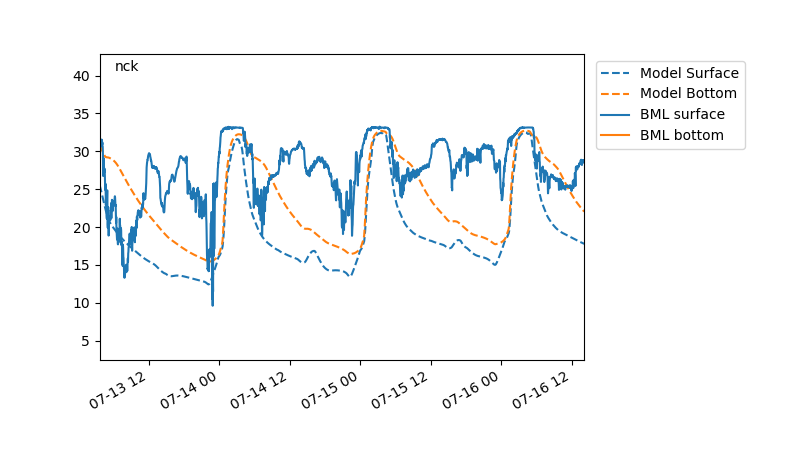

In [392]:
FigSalt(his_ds,b'nck',bml_nck_sfc_mcat,bml_nck_btm_mcat)

<IPython.core.display.Javascript object>


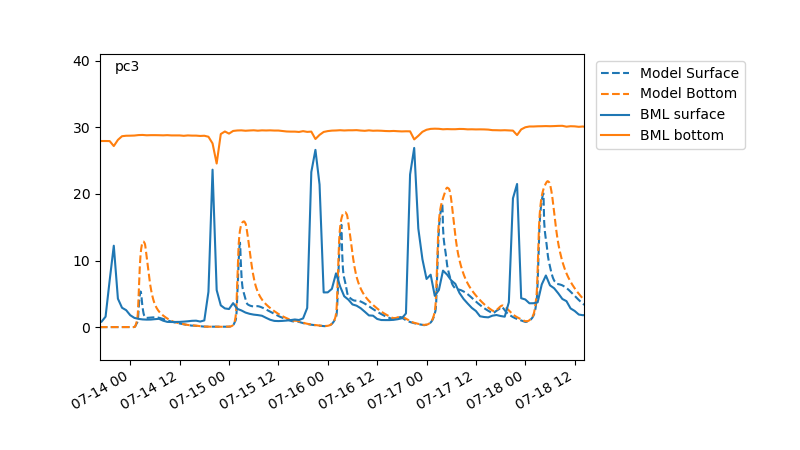

In [204]:
FigSalt(his_ds,b'pc3',bml_pc3_sfc_sond,bml_pc3_btm_sond)

<IPython.core.display.Javascript object>


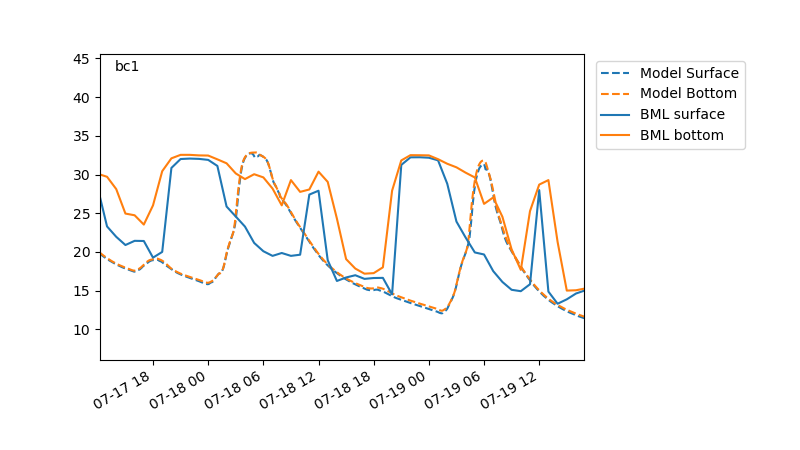

In [205]:
FigSalt(his_ds,b'bc1',bml_bc1_sfc_sond,bml_bc1_btm_sond)

<IPython.core.display.Javascript object>


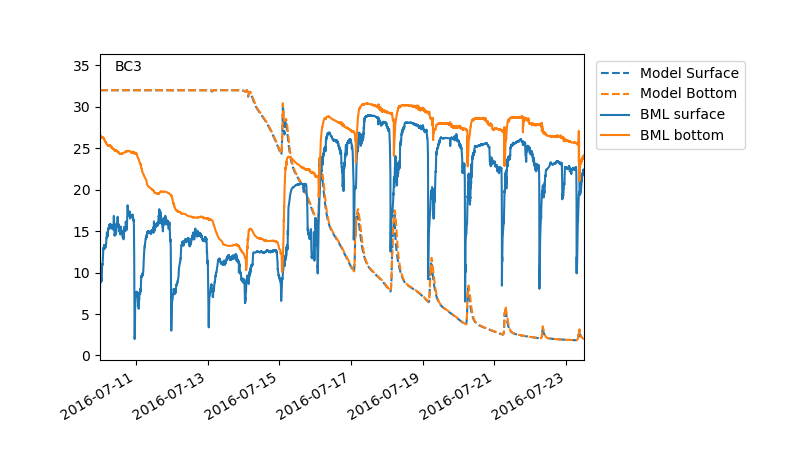

In [206]:
FigSalt(his_ds,b'BC3',bml_bc3_sfc_mcat,bml_bc3_btm_mcat)

<IPython.core.display.Javascript object>


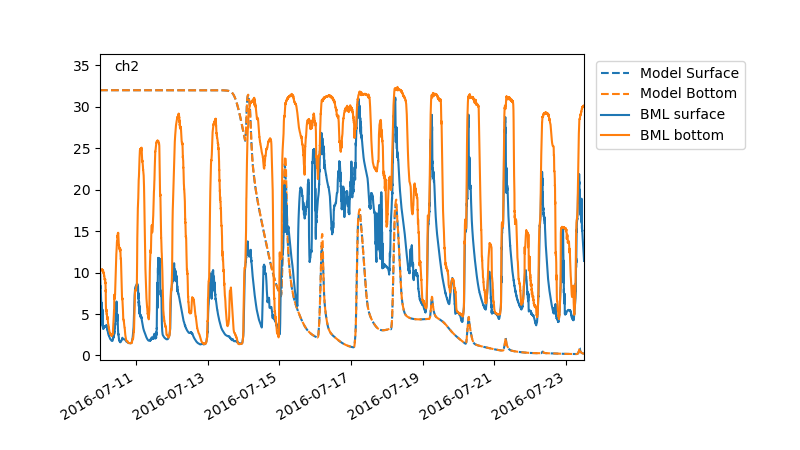

In [207]:
FigSalt(his_ds,b'ch2',bml_ch2_sfc_mcat,bml_ch2_btm_mcat)

Compare BCs
--

Seem to be fine


In [341]:
bcs=model.load_bcs()
bc_names=[bc['name'] for bc in bcs]
pesca_ck_bc=bcs[bc_names.index('pescadero_ck')]
butano_ck_bc=bcs[bc_names.index('butano_ck')]

Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd


In [342]:
# USGS gauge: 11162500
from stompy.io.local import usgs_nwis

da=pesca_ck_bc['data']
pesca_usgs=usgs_nwis.nwis_dataset(11162500,start_date=da.time.values[0],
                                  end_date=da.time.values[-1],
                                  products=[60])

INFO:usgs_nwis:Fetching 11162500_60_2016-07-01_2016-08-01.nc


In [343]:
his_ds.close()
his_ds=xr.open_dataset(model.his_output())

In [344]:
his_ds.cross_section_name

<xarray.DataArray 'cross_section_name' (cross_section: 10)>
array([b'mouth_xs', b'n_pond_xs', b'n_ditch_xs', b'n_complex_xs',
       b'pesca_mid_xs', b'butano_lower_xs', b'pesca_lower_xs', b'pesca_bc_xs',
       b'butano_bc_xs', b'butano_mid_xs'], dtype='|S64')
Coordinates:
    cross_section_name  (cross_section) |S64 b'mouth_xs' ... b'butano_mid_xs'
Dimensions without coordinates: cross_section
Attributes:
    cf_role:    timeseries_id
    long_name:  cross section name

In [364]:
from stompy import filters 

In [363]:
his_ds['cross_section_discharge'].isel(cross_section=0).mean()

<xarray.DataArray 'cross_section_discharge' ()>
array(-0.11390233)
Coordinates:
    cross_section_name  |S64 b'mouth_xs'

In [367]:
np.median(np.diff(his_ds.time.values))/np.timedelta64(60,'s')

5.0

<IPython.core.display.Javascript object>


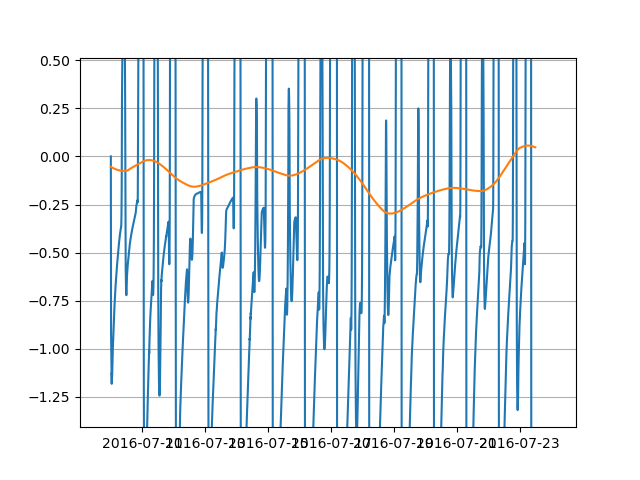

In [368]:
plt.figure()

plt.plot(his_ds.time, his_ds['cross_section_discharge'].isel(cross_section=0) )
plt.plot(his_ds.time, 
         filters.lowpass_godin(his_ds['cross_section_discharge'].isel(cross_section=0).values,
                               mean_dt_h=5./60))


<IPython.core.display.Javascript object>


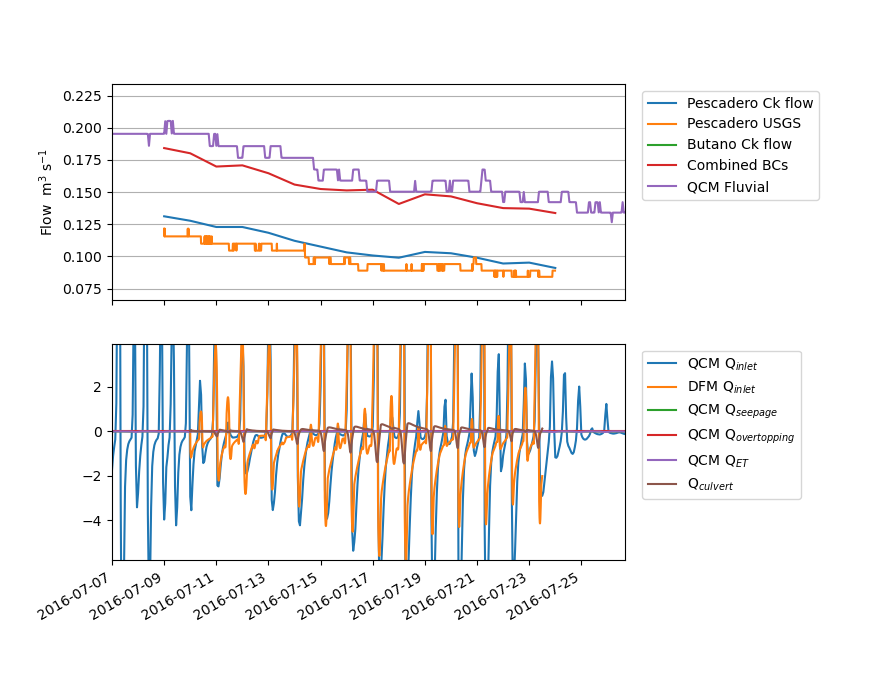

In [354]:
mouth=his_ds.isel(cross_section=0)
fig,(ax,ax_other)=plt.subplots(2,1,sharex=True)

Q=pesca_ck_bc['data']
ax.plot(Q.time, Q.flow, label="Pescadero Ck flow")

ax.plot(pesca_usgs.time,
        pesca_usgs.stream_flow_mean_daily * 0.3048**3,
        label='Pescadero USGS')

Q=butano_ck_bc['data']
ax.plot(Q.time, Q.flow, label="Butano Ck flow")

Q_comb=butano_ck_bc['data'].flow + pesca_ck_bc['data'].flow
ax.plot(Q_comb.time, Q_comb, label="Combined BCs")

ax.plot(qcm.time, qcm['combined fluvial'] * 0.3048**3,label='QCM Fluvial')
ax.legend(loc='upper left',bbox_to_anchor=[1.02,1])

fig.subplots_adjust(right=0.70)

ax.set_ylabel('Flow  m$^3$ s$^{-1}$')
ax.axis(xmin=da.time.values[0],xmax=da.time.values[-1],ymin=-0.05,ymax=0.65)

# And other fluxes:
ax_other.plot(qcm.time, qcm['Modeled inlet flow'] * 0.3048**3,label='QCM Q$_{inlet}$')
ax_other.plot(mouth.time, mouth['cross_section_discharge'],label="DFM Q$_{inlet}$" )

ax_other.plot(qcm.time, qcm['Modeled seepage'] * 0.3048**3,label='QCM Q$_{seepage}$')
ax_other.plot(qcm.time, qcm['Modeled wave overtopping'] * 0.3048**3,label='QCM Q$_{overtopping}$')
ax_other.plot(qcm.time, qcm['Modeled ET'] * 0.3048**3,label='QCM Q$_{ET}$')

ax_other.plot( his_ds.time, his_ds['gategen_discharge'].isel(gategens=0),
              label='Q$_{culvert}$')

ax_other.legend(loc='upper left',bbox_to_anchor=[1.02,1])
ax_other.axis(ymin=-40,ymax=40)

fig.autofmt_xdate()

<IPython.core.display.Javascript object>


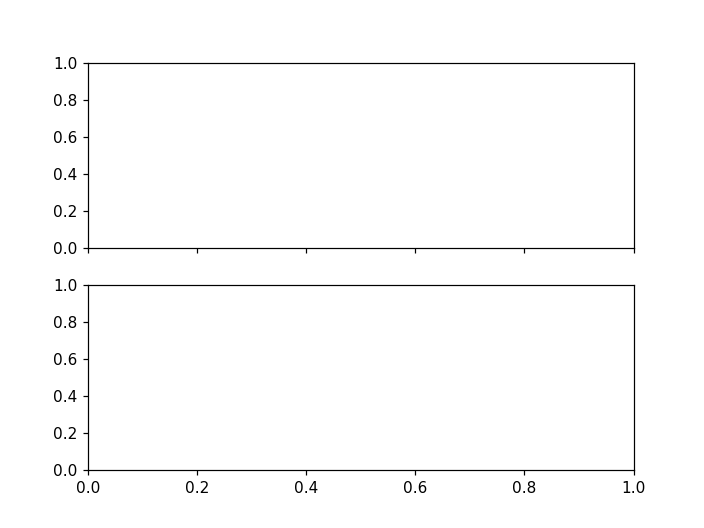

In [33]:
stn_ds=his_ds.isel(stations=7) # nck

fig,axs=plt.subplots(2,1,sharex=True)
for ax,v in zip(axs,['tke','vicww']):
    if v not in stn_ds: continue
    img=ax.imshow(stn_ds[v].values.T.clip(1e-7),aspect="auto",norm=colors.LogNorm(vmin=1e-7,vmax=1e-3),
                  cmap='turbo',origin='lower')
    plt.colorbar(img,ax=ax,label=v)


In [116]:
from stompy.grid import multi_ugrid
import six
six.moves.reload_module(multi_ugrid)

mu=multi_ugrid.MultiUgrid(paths="run_salt_20160520-v64/DFM_OUTPUT_flowfm/*_map.nc",
                          cleanup_dfm=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

In [451]:
versions=["v83","v84"]

his_fns=[f"run_salt_20160520-{ver}/DFM_OUTPUT_flowfm/flowfm_0000_his.nc"
         for ver in versions]
try:
    [ds.close() for ds in hiss]
except NameError:
    pass

#his_fns.append(f"run_salt_20160520-v76/DFM_OUTPUT_flowfm/flowfm_his.nc")
#versions.append('v76')

hiss=[]
for fn in his_fns:
    try:
        ds=xr.open_dataset(fn)
    except OverflowError:
        # workaround -- some sort of issue with the timestamps in 
        # this one.
        ds=xr.open_dataset(fn,decode_times=False)
        ds['time']=ds.time.astype(np.int64)
        ds=xr.decode_cf(ds)
    hiss.append(ds)


ncks=[ his.isel(stations=7) for his in hiss]

<IPython.core.display.Javascript object>


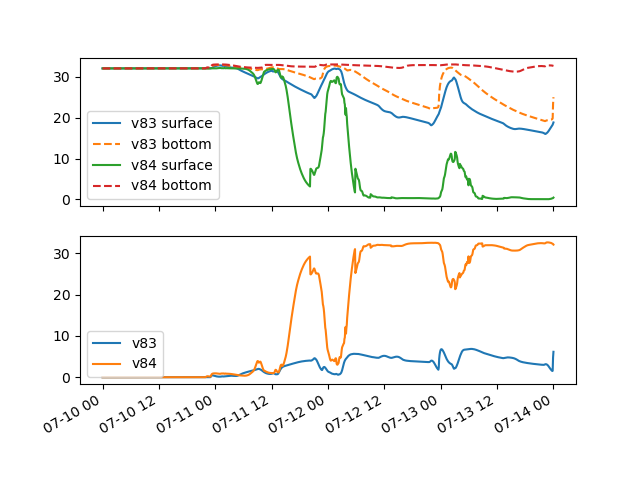

In [452]:
fig,axs=plt.subplots(2,1,sharex=True)

for ver,nck in zip(versions,ncks):
    surf=surface(nck['salinity'])
    bott=bottom(nck['salinity'])
    axs[0].plot(nck.time, surf, label=ver+' surface')
    axs[0].plot(nck.time, bott, label=ver+' bottom',ls='--')
    axs[1].plot(nck.time, bott-surf, label=ver)

axs[0].legend(loc='lower left')
axs[1].legend(loc='lower left')
fig.autofmt_xdate()

In [460]:
ncks[0]

<xarray.Dataset>
Dimensions:                                  (cross_section: 10, gategens: 3, general_structures: 2, laydim: 28, laydimw: 29, nFlowElemContourPts: 4, nFlowElemWithBnd: 5705, nFlowLink: 8832, nFlowLinkPts: 2, nNetLink: 9154, nNetLinkPts: 2, station_geom_nNodes: 15, time: 1153)
Coordinates:
    station_x_coordinate                     float64 5.524e+05
    station_y_coordinate                     float64 4.124e+06
    station_name                             |S64 b'nck'
    zcoordinate_c                            (time, laydim) float64 nan ... nan
    zcoordinate_w                            (time, laydimw) float64 nan ... nan
    zcoordinate_wu                           (time, laydimw) float64 nan ... nan
    cross_section_name                       (cross_section) |S64 b'mouth_xs'...
    general_structure_id                     (general_structures) |S64 b'mout...
    gategen_name                             (gategens) |S64 b'pch_gate' ... ...
  * time                                     (time) datetime64[ns] 2016-07-10...
Dimensions without coordinates: cross_section, gategens, general_structures, laydim, laydimw, nFlowElemContourPts, nFlowElemWithBnd, nFlowLink, nFlowLinkPts, nNetLink, nNetLinkPts, station_geom_nNodes
Data variables:
    FlowElem_xcc                             (nFlowElemWithBnd) float64 5.526...
    FlowElem_ycc                             (nFlowElemWithBnd) float64 4.123...
    FlowElem_zcc                             (nFlowElemWithBnd) float64 -1.65...
    FlowElem_bac                             (nFlowElemWithBnd) float64 21.54...
    FlowElem_xzw                             (nFlowElemWithBnd) float64 5.526...
    FlowElem_yzw                             (nFlowElemWithBnd) float64 4.123...
    FlowElemContour_x                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElemContour_y                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElem_bl                              (nFlowElemWithBnd) float64 1.659...
    ElemLink                                 (nNetLink, nNetLinkPts) int32 1 ...
    FlowLink                                 (nFlowLink, nFlowLinkPts) int32 ...
    FlowLinkType                             (nFlowLink) int32 2 2 2 2 ... 2 2 2
    FlowLink_xu                              (nFlowLink) float64 5.526e+05 .....
    FlowLink_yu                              (nFlowLink) float64 4.123e+06 .....
    projected_coordinate_system              int32 -2147483647
    FlowLink_lonu                            (nFlowLink) float64 9.969e+36 .....
    FlowLink_latu                            (nFlowLink) float64 9.969e+36 .....
    FlowElemDomain                           (nFlowElemWithBnd) int32 5 5 ... 7
    FlowLinkDomain                           (nFlowLink) int32 0 0 0 0 ... 0 0 0
    FlowElemGlobalNr                         (nFlowElemWithBnd) int32 62511 ....
    station_id                               |S64 b'nck'
    station_geom                             int32 -2147483647
    station_geom_node_count                  int32 1
    station_geom_node_coordx                 (station_geom_nNodes) float64 5....
    station_geom_node_coordy                 (station_geom_nNodes) float64 4....
    waterlevel                               (time) float64 1.42 1.419 ... 1.384
    bedlevel                                 float64 0.1301
    x_velocity                               (time, laydim) float64 nan ... nan
    y_velocity                               (time, laydim) float64 nan ... nan
    z_velocity                               (time, laydim) float64 nan ... nan
    depth-averaged_x_velocity                (time) float64 0.0 ... 0.08952
    depth-averaged_y_velocity                (time) float64 0.0 ... -0.009286
    tke                                      (time, laydimw) float64 nan ... nan
    vicww                                    (time, laydimw) float64 nan ... nan
    eps                                      (time, laydimw) f

<IPython.core.display.Javascript object>


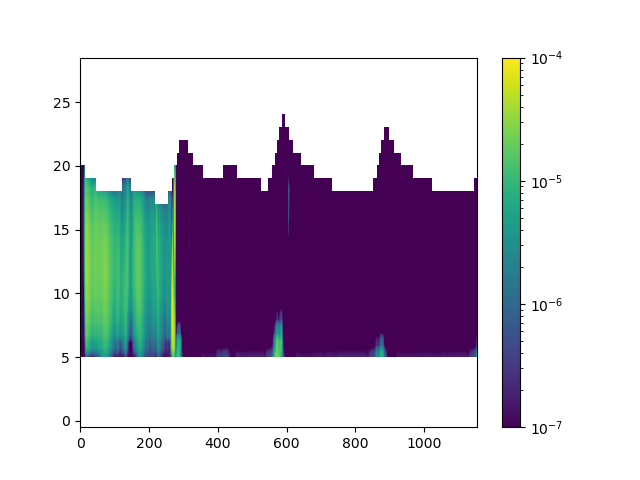

In [458]:
plt.figure()
from matplotlib import colors

img=plt.imshow( ncks[0].vicww.values.T, aspect='auto',origin='lower',
                norm=colors.LogNorm(vmin=1e-7,vmax=1e-4))
plt.colorbar(img)

In [448]:
# did I manage to actually more layers in v83?
for nck in [ncks[0],ncks[2]]:
    display(nck['salinity'].isel(time=1000))
    

<xarray.DataArray 'salinity' (laydim: 28)>
array([      nan,       nan,       nan, 24.645521, 24.384358, 23.829141,
       23.112437, 22.296463, 21.476686, 20.760543, 20.152692, 19.671831,
       19.512516,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan])
Coordinates:
    station_x_coordinate  float64 ...
    station_y_coordinate  float64 ...
    station_name          |S64 ...
    zcoordinate_c         (laydim) float64 ...
    time                  datetime64[ns] 2016-07-13T11:20:00
Dimensions without coordinates: laydim
Attributes:
    units:          1e-3
    geometry:       station_geom
    standard_name:  salinity

<xarray.DataArray 'salinity' (laydim: 28)>
array([      nan,       nan,       nan,       nan, 24.589791, 24.521371,
       24.368578, 24.114651, 23.74893 , 23.310877, 22.83799 , 22.336252,
       21.816276, 21.304201, 20.833517, 20.425156, 20.065017, 19.758565,
       19.53525 , 19.474027,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan])
Coordinates:
    station_x_coordinate  float64 5.524e+05
    station_y_coordinate  float64 4.124e+06
    station_name          |S64 b'nck'
    zcoordinate_c         (laydim) float64 nan nan nan nan ... nan nan nan nan
    time                  datetime64[ns] 2016-07-13T11:20:00
Dimensions without coordinates: laydim
Attributes:
    units:          1e-3
    geometry:       station_geom
    standard_name:  salinity

<IPython.core.display.Javascript object>


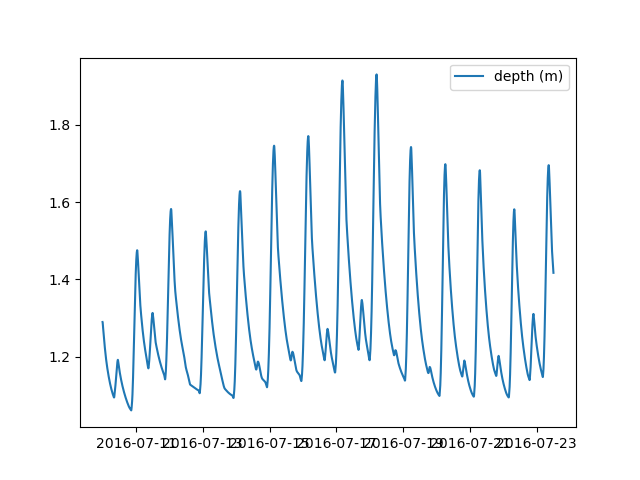

In [429]:
plt.figure()
plt.plot(ncks[0].time,
         ncks[0].waterlevel- ncks[0].bedlevel,
         label='depth (m)')
plt.legend()

In [333]:
# Check v66 for checkboarding

from stompy.grid import multi_ugrid
import six
six.moves.reload_module(unstructured_grid)
six.moves.reload_module(multi_ugrid)

mu=multi_ugrid.MultiUgrid(paths="run_salt_20160520-v73/DFM_OUTPUT_flowfm/*_map.nc",
                          cleanup_dfm=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

<IPython.core.display.Javascript object>


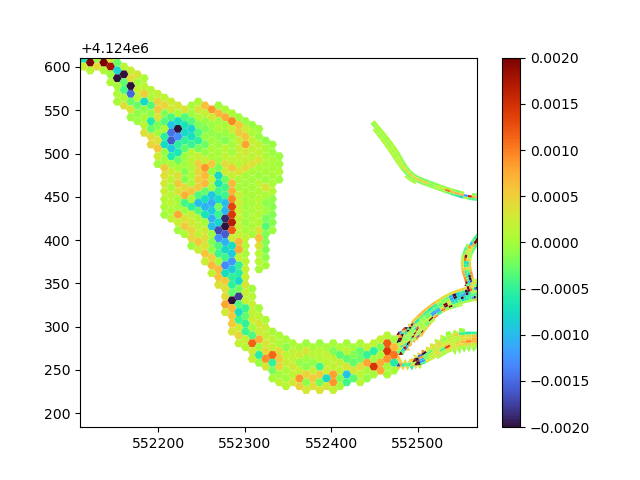

(552109.707977934, 552568.1970982167, 4124195.74689635, 4124598.8779694755)

In [334]:
plt.figure()
#w=mu['mesh2d_ww1'].isel(time=-3,mesh2d_nInterfaces=11)
w=mu['mesh2d_ucz'].isel(time=-1,mesh2d_nLayers=11)

ccoll=mu.grid.plot_cells(values=w,clim=[-0.002,0.002],cmap='turbo')
plt.colorbar(ccoll)
plt.axis('equal')
plt.axis((552109.707977934, 552568.1970982167, 4124195.74689635, 4124598.8779694755))

<IPython.core.display.Javascript object>


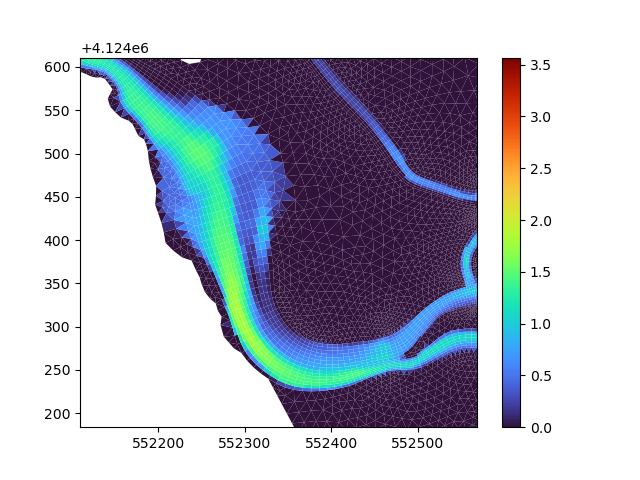

(552109.707977934, 552568.1970982167, 4124195.74689635, 4124598.8779694755)

In [311]:
plt.figure()
d=mu['mesh2d_waterdepth'].isel(time=-1)

ccoll=mu.grid.plot_cells(values=d,cmap='turbo')
plt.colorbar(ccoll)
plt.axis('equal')
plt.axis((552109.707977934, 552568.1970982167, 4124195.74689635, 4124598.8779694755))

In [ ]:
# A lot more checkerboarding in ucz than in ww1.
# What's up with that?

In [306]:
mu.dss[0].mesh2d_ww1

<xarray.DataArray 'mesh2d_ww1' (time: 55, mesh2d_nFaces: 5705, mesh2d_nInterfaces: 29)>
[9099475 values with dtype=float64]
Coordinates:
    mesh2d_face_x  (mesh2d_nFaces) float64 5.526e+05 5.526e+05 ... 5.531e+05
    mesh2d_face_y  (mesh2d_nFaces) float64 4.123e+06 4.123e+06 ... 4.124e+06
  * time           (time) datetime64[ns] 2016-07-10 ... 2016-07-23T12:00:00
Dimensions without coordinates: mesh2d_nFaces, mesh2d_nInterfaces
Attributes:
    mesh:           mesh2d
    location:       face
    cell_methods:   mesh2d_nFaces: mean
    cell_measures:  area: mesh2d_flowelem_ba
    standard_name:  upward_sea_water_velocity
    long_name:      Upward velocity on vertical interface, n-component
    units:          m s-1
    grid_mapping:   projected_coordinate_system

In [307]:
mu.dss[0].mesh2d_ucz

<xarray.DataArray 'mesh2d_ucz' (time: 55, mesh2d_nFaces: 5705, mesh2d_nLayers: 28)>
[8785700 values with dtype=float64]
Coordinates:
    mesh2d_face_x  (mesh2d_nFaces) float64 5.526e+05 5.526e+05 ... 5.531e+05
    mesh2d_face_y  (mesh2d_nFaces) float64 4.123e+06 4.123e+06 ... 4.124e+06
  * time           (time) datetime64[ns] 2016-07-10 ... 2016-07-23T12:00:00
Dimensions without coordinates: mesh2d_nFaces, mesh2d_nLayers
Attributes:
    mesh:           mesh2d
    location:       face
    cell_methods:   mesh2d_nFaces: mean
    standard_name:  upward_sea_water_velocity
    long_name:      Flow element center velocity vector, z-component
    units:          m s-1
    grid_mapping:   projected_coordinate_system

In [301]:
plt.axis()

(552109.707977934, 552568.1970982167, 4124195.74689635, 4124598.8779694755)

In [378]:
his_ds=xr.open_dataset("run_salt_20160520-v74/DFM_OUTPUT_flowfm/flowfm_0000_his.nc")
his_ds.close()
his_ds=xr.open_dataset("run_salt_20160520-v74/DFM_OUTPUT_flowfm/flowfm_0000_his.nc")



In [379]:
his_ds

<xarray.Dataset>
Dimensions:                                  (cross_section: 10, gategens: 3, general_structures: 2, laydim: 10, laydimw: 11, nFlowElemContourPts: 4, nFlowElemWithBnd: 5705, nFlowLink: 8832, nFlowLinkPts: 2, nNetLink: 9154, nNetLinkPts: 2, station_geom_nNodes: 15, stations: 15, time: 627)
Coordinates:
    station_x_coordinate                     (stations) float64 ...
    station_y_coordinate                     (stations) float64 ...
    station_name                             (stations) |S64 ...
    zcoordinate_c                            (time, stations, laydim) float64 ...
    zcoordinate_w                            (time, stations, laydimw) float64 ...
    zcoordinate_wu                           (time, stations, laydimw) float64 ...
    cross_section_name                       (cross_section) |S64 ...
    general_structure_id                     (general_structures) |S64 ...
    gategen_name                             (gategens) |S64 ...
  * time                                     (time) datetime64[ns] 2016-07-10...
Dimensions without coordinates: cross_section, gategens, general_structures, laydim, laydimw, nFlowElemContourPts, nFlowElemWithBnd, nFlowLink, nFlowLinkPts, nNetLink, nNetLinkPts, station_geom_nNodes, stations
Data variables:
    FlowElem_xcc                             (nFlowElemWithBnd) float64 ...
    FlowElem_ycc                             (nFlowElemWithBnd) float64 ...
    FlowElem_zcc                             (nFlowElemWithBnd) float64 ...
    FlowElem_bac                             (nFlowElemWithBnd) float64 ...
    FlowElem_xzw                             (nFlowElemWithBnd) float64 ...
    FlowElem_yzw                             (nFlowElemWithBnd) float64 ...
    FlowElemContour_x                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElemContour_y                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElem_bl                              (nFlowElemWithBnd) float64 ...
    ElemLink                                 (nNetLink, nNetLinkPts) int32 ...
    FlowLink                                 (nFlowLink, nFlowLinkPts) int32 ...
    FlowLinkType                             (nFlowLink) int32 ...
    FlowLink_xu                              (nFlowLink) float64 ...
    FlowLink_yu                              (nFlowLink) float64 ...
    projected_coordinate_system              int32 ...
    FlowLink_lonu                            (nFlowLink) float64 ...
    FlowLink_latu                            (nFlowLink) float64 ...
    FlowElemDomain                           (nFlowElemWithBnd) int32 ...
    FlowLinkDomain                           (nFlowLink) int32 ...
    FlowElemGlobalNr                         (nFlowElemWithBnd) int32 ...
    station_id                               (stations) |S64 ...
    station_geom                             int32 ...
    station_geom_node_count                  (stations) int32 ...
    station_geom_node_coordx                 (station_geom_nNodes) float64 ...
    station_geom_node_coordy                 (station_geom_nNodes) float64 ...
    waterlevel                               (time, stations) float64 ...
    bedlevel                                 (stations) float64 ...
    x_velocity                               (time, stations, laydim) float64 ...
    y_velocity                               (time, stations, laydim) float64 ...
    z_velocity                               (time, stations, laydim) float64 ...
    depth-averaged_x_velocity                (time, stations) float64 ...
    depth-averaged_y_velocity                (time, stations) float64 ...
    tke                                      (time, stations, laydimw) float64 ...
    vicww                                    (time, stations, laydimw) float64 ...
    eps                                      (time, stations, laydimw) float64 ...
    salinity                                 (time, stations, laydim) float64 ...
   

<IPython.core.display.Javascript object>


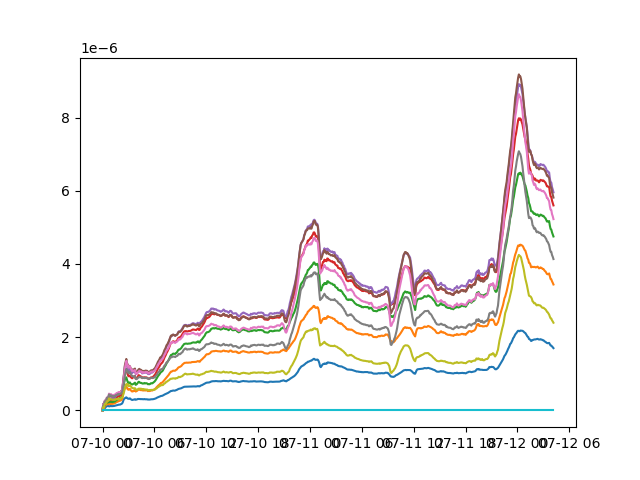

In [380]:
plt.figure()
plt.plot(his_ds.time, his_ds.checkerboard_monitor)